# Naive Bayes Document Classification

**COMP9418-17s2, W01 Tutorial**

- Instructor: Edwin V. Bonilla
- School of Computer Science and Engineering, UNSW Sydney 
- Questions by Daniel Mackinlay (with input and edits from Edwin V. Bonilla)

In this week's tutorial, we will further explore
the basis of the Naïve Bayes Classifier.
We will use, specifically, the Bernoulli-Dirichlet model for text classification,
We will train the model using both the Maximum Likelihood estimates and Bayesian updating,
and compare these in terms of predictive success, and in terms of what can go wrong.

We will be using the `webkb` dataset.
This data set contains web pages collected from computer science departments
of various universities in January 1997
by the _World Wide Knowledge Base_ project of the _CMU text learning group_.

The pages have been manually classified into categories;
our goal is to classify documents into those categories using the content of the page.

The original data is full HTML files.
If you would like to see the original data, or learn more about it,
see [the webkb dataset website](http://www.cs.cmu.edu/afs/cs/project/theo-20/www/data/).

We have preprocessed a subset of that data into numerical arrays,
to which we can apply the classifier directly.
(But if you are interested in learning to process the text yourself, feel free to use the original data.)

## Technical prerequisites

You will need certain packages installed to run this notebook.

If you are using ``conda``'s default
[full installation](https://conda.io/docs/install/full.html),
these requirements should all be satisfied already.

If you are using ``virtualenv`` or other native package management,
you may need to run these commands:

```python
pip install scipy matplotlib
```

You will also need to download the preprocessed `webkb` data set
(see file `webkb.npz` in WebCMS3)
and put it in the same folder as this notebook.

Once we have done all that, we
import some useful modules for later use.

In [1]:
# Make division default to floating-point, saving confusion
from __future__ import division

# Necessary libraries
import scipy as sp
import numpy as np
import matplotlib.pyplot as pl

# Put the graphs where we can see them
%matplotlib inline

# Display a warning on important floating-point errors
np.seterr(divide='warn', invalid='warn');

# The Data

## Loading the data

These data are in `npz` compressed `numpy` format, which can be loaded using `np.load`.
Make sure you have downloaded the data first!

In [2]:
data = np.load(
    'webkb.npz',
)

# training data
xtrain = data['xtrain']
ytrain = data['ytrain']

# test data
xtest = data['xtest']
ytest = data['ytest']

# which class is which?
class_label_strings = data['class_label_strings']

# we don't need the original any more
del(data)

Additionally, here is a useful function for plotting bar charts from this data set.

In [3]:
def categorical_bar(val, **kwargs):
    """
    Convenient categorical bar plot, labelled with the class strings.
    This is handy if you want to plot something versus class.
    """
    n_cat = len(class_label_strings)
    cat_index = np.arange(n_cat)
    bar = pl.bar(cat_index, val, width=1, **kwargs);
    pl.xticks(cat_index, class_label_strings)
    return bar

## Exploring the data

The $X$ arrays above are the *features*.
Each array is an $N \times D$ matrix,
whose rows correspond to the number of training points-
so $N$ is the number of data points,
and $D$ is the number of features.

The $Y$ arrays, $Y^\text{train}$ and $Y^\text{test}$ are $N \times C$ column vectors,
each row containing the one-hot encoded class label of the corresponding training point.

The data sets are divided into *training* and *test* sets;
We will not be using the test data except to test predictions later in the tutorial.

Each data point represents one text _document_ -
in this data set, one document equals one web page.
The features here are indicators of the presence, or absence, of a word in a given page.
So if $X_{ij}=1$, we know that document $i$ contains word $j$.
In this data set, however, we do not know which feature corresponds to which word.
This is a special case of the _bag of words_ method, and it will allow us to model
the document features using Bernoulli random variables.


Given that description, we check the data has the size we expect:

In [6]:
print("X training data dimensions = {!r}".format(xtrain.shape))
print("Y training data dimensions = {!r}".format(ytrain.shape))
print("X test data dimensions     = {!r}".format(xtest.shape))
print("Y test data dimensions     = {!r}".format(ytest.shape))
print("Number of y labels         = {!r}".format(len(class_label_strings)))


X training data dimensions = (702, 1703)
Y training data dimensions = (702, 5)
X test data dimensions     = (175, 1703)
Y test data dimensions     = (175, 5)
Number of y labels         = 5


Next, we inspect the content of the arrays.

## Features

We can plot frequencies of all the features/words.

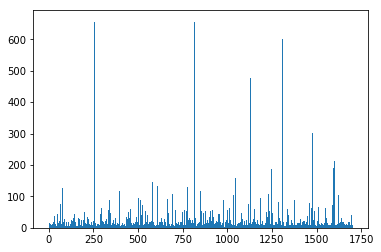

In [9]:
pl.bar(np.arange(xtrain.shape[1]), np.sum(xtrain, axis=0), width=1);

### Exercise

Plot the class-conditional features density for two different classes -
that is, given, say, class $2$ and class $3$, plot what proportion the examples in each class have which features.

ValueError: incompatible sizes: argument 'height' must be length 1703 or scalar

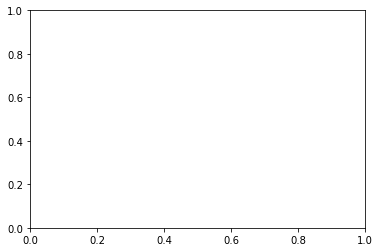

In [13]:
x2 = xtrain[ytrain[:, 2] == 1, :]
x3 = xtrain[ytrain[:, 3] == 1, :]

pl.bar(np.arange(x2.shape[1]), np.mean(x2), width=1);
pl.bar(np.arange(x3.shape[1]), np.mean(x3), width=1);

## Classes

So much for the $X$ arrays. How about the $Y$ arrays?

### Exercise

Plot the number of training documents in each class in the training data.
Identify the smallest and largest classes.
Are they evenly distributed? What effect will this have on our results?

# Maximum Likelihood Naïve Bayes Classifier

## Parameter estimation

With regard to the MLE fitting, the classifier is specified by the following parameters

- $\boldsymbol{\pi}$, where $\pi_c=p(y=c)$ the marginal probability that a document is in category $c$
- $\boldsymbol{\theta}$, where $\theta_{jc}=p(x_{j}=1|y_c=1),$ the class-conditional probability of each feature.


We construct ML point estimates of the vector parameters
$\hat{\boldsymbol{\pi}}$ 
and 
$\hat{\boldsymbol{\theta}}$.

The MLE estimates may be calculated as follows (Using the notation of Murphy, 3.5)

For the class probabilities,
$$
\hat{\pi}_c=\frac{N_c}{N},
$$
where $N_c$ is the number of examples in class $c$.

For the conditional feature probabilities,
$$\hat{\theta}_{jc}=\frac{N_{jc}}{N_c},$$
where $N_{jc}$ is the number of occurrences of feature $j$ in class $c$.

Here is a function to calculate this for you:

In [14]:
def fit_naive_bayes_ml(x, y):
    """
    Given an array of features `x` and an array of labels `y`,
    return ML estimates of class probabilities `pi` and
    class-conditional feature probabilities `theta`.
    """
    n_class = y.shape[1]
    n_feat = x.shape[1]
    
    pi_counts = np.sum(y, axis=0)
    pi = pi_counts/np.sum(pi_counts)
    
    theta = np.zeros((n_feat, n_class))

    for cls in range(n_class):
        docs_in_class = (y[:, cls]==1)
        class_feat_count = x[docs_in_class, :].sum(axis=0)
        theta[:, cls] = class_feat_count/(docs_in_class.sum())
    return pi, theta

In [15]:
pi_hat, theta_hat = fit_naive_bayes_ml(xtrain, ytrain)

### Exercise
Plot the class probabilites obtained by the ML estimator using the `categorical_bar` function.
How different is it from the proportion of classes in each category that we plotted earlier?

## Prediction

Now we implement the class probability predictor, given our parameter estimates.
This will involve two functions.
One function, `predict_class_prob`, will give the posterior class likelihood for a given document.
The second function, `predict_class`,
will choose the highest-probability class as a MAP-prediction for a given document.

These function are provided for you.

In [16]:
from scipy.misc import logsumexp

def predict_class_prob(x, pi, theta):
    """
    Given an single array of features `x`,
    class probability estimate `pi` and
    class-conditional feature probability estimate `theta`,
    return predictive class probabilities.
    """
    class_feat_l = np.zeros_like(theta)
    
    # calculations in log space to avoid underflow
    class_feat_l[x==1, :] = np.log(theta[x==1, :])
    class_feat_l[x==0, :] = np.log(1 - theta[x==0, :])
    class_l = class_feat_l.sum(axis=0) + np.log(pi)
    return np.exp(class_l - logsumexp(class_l))


def predict_class(x, pi, theta):
    """
    Given a feature vector `x`, class probabilities `pi`
    and class-conditional feature probabilities `theta`,
    return a one-hot encoded MAP class-membership prediction.
    """
    probs = predict_class_prob(x, pi, theta)
    prediction = np.zeros_like(probs)
    prediction[np.argmax(probs)] = 1
    return prediction

If you implement these predictors using likelihoods without the **log-sum-exp** trick, what happens?

Let's look at the some predicted probabilities under this model.

Consider the first example from the test set, $X^\text{test}_{0,:}$.
Its true class membership (one-hot encoded) is  $Y^\text{test}_{0,:}$.
We can plot this and see that this document is a "Student" web page.

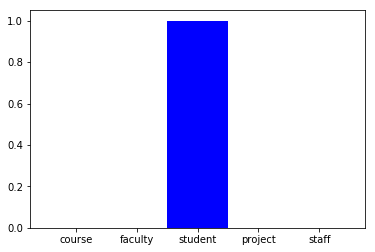

In [17]:
categorical_bar(ytest[0,:], label="$y$", color='blue');


### Exercise
Plot the predicted class probabilities for the first training example
$X^\text{test}_{0,:}$:

You may of course repeat this exercise for other examples.

## Test set performance

We can in principle infer class probabilities for any given example.
But since we have a lot of these,
we will define a helper function to quantify how good our predictions are over a whole data set.

We assign a score of $1$ for a correct MAP prediction, or $0$ for an incorrect prediction.
The mean of these is a measure of the quality of our predictor.

In [18]:
def predictive_accuracy(xdata, ydata, predictor, *args):
    """
    Given an N-by-D array of features `xdata`,
    an N-by-C array of one-hot-encoded true classes `ydata`
    and a predictor function `predictor`,
    return the proportion of correct predictions.
    
    We accept an additional argument list `args`
    that will be passed to the predictor function.
    """
    correct = np.zeros(xdata.shape[0])
    for i, x in enumerate(xdata):
        prediction = predictor(x, *args)
        correct[i] = np.all(ydata[i, :] == prediction)
    return correct.mean()

How well did we do?
We examine our performance on the held-out test data.


In [19]:
test_correct_ml = predictive_accuracy(xtest, ytest, predict_class, pi_hat, theta_hat)
print("ML Out-of-sample proportion correct: {:.3}".format(test_correct_ml))

ML Out-of-sample proportion correct: 0.606


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in subtract


### Exercise
Calculate this accuracy metric on the training data.
What does it tell us?

## Diagnosis: What are these warnings about?

These results lead to two questions:

1. Is the accuracy  any good?
2. Do all these  `RuntimeWarning: divide by zero` messages mean anything?


### Exercise
Look at test document number 48.
Plot the predicted class probabilites.
What is wrong in this case?

### Exercise
Have we over- or under-estimated our predictor's test-set success on the basis of this diagnosis?

### Exercise
Alter the function `predict_class` belo to detect
this failure mode, and to return a “likelihood” of $(0 0 0 0 0)$ in this case.

In [22]:
def predict_class(x, pi, theta):
    """
    Given a feature vector `x`, class probabilities `pi`
    and class-conditional feature probabilities `theta`,
    Return a one-hot encoded class-membership prediction.
    If the class probabilities are ill-defined, return a null prediction.
    """
   

Note that this doesn't fix the prediction - but it gives us a more realistic perspective on the performance of the estimator.
(What other solutions might be better?)

**Pro tip**: to keep things tidy now in the notebook, we can disable these `Warning` messages.
```
np.seterr(divide='ignore', invalid='ignore');
```
In general, you should _not_ do this unless you have very good reason to think that the warnings are unimportant.

Now re-test the model without spurious predictions.

# Bayesian Naïve Bayes Classifier

We start with, as in the class, a Dirichlet prior for the classes, and an identical Beta prior for each class-conditional feature probability:

$$\begin{aligned}
\boldsymbol{\pi}&\sim\operatorname{Dir}(\boldsymbol{\alpha})\\
\theta_{jc}&\sim\operatorname{Beta}(\boldsymbol{\beta}) \text{ for each }j, c
\end{aligned}$$

Note that the parameters of the prior distributions are both vectors,
$\boldsymbol{\alpha}=(\alpha_1, \alpha_2, \dots, \alpha_C)$ and $\boldsymbol{\beta}=(\beta_0, \beta_1).$


## Posterior updates

In a fully Bayesian setting, we would calculate full posteriors for all model parameters.
However, in this predictive task, we only use posterior means $\bar{\boldsymbol{\theta}}$
and $\bar{\boldsymbol{\pi}}$,
so it will be sufficient (and a little bit simpler) to calculate just these.

Recall
$$
\bar{\pi}_c=\frac{N_c+\alpha_c}{N+\alpha_0},
$$
where $\alpha_0$ means $\sum_c \alpha_c.$

For the conditional feature probabilities,
$$
\bar{\theta}_{jc}=\frac{N_{jc}+\beta_1}{N_c+\beta_0+\beta_1}.
$$


### Exercise
Below is the skeleton of the function `naive_bayes_posterior_mean`.
Fill in the body of this function so that it calculates the desired posterior means.
You are recommended to copy `fit_naive_bayes_ml`, above, and modify it.

In [1]:
def naive_bayes_posterior_mean(x, y, alpha=1, beta=1):
    """
    Given an array of features `x`,
    an array of labels `y`,
    class prior Dirichlet parameter `alpha`, and
    common class-conditional feature expectation `beta`
    return 
    
    a posterior mean, `pi`, of `alpha` and
    a posterior mean, `theta` of the `beta`.
    
    NB: this is not the same as returning the parameters of the full posterior,
    but it is sufficient to calculate the posterior predictive density.
    """
   

Now, let's calculate these values.
We need to choose our priors.
Since we know we would like *some* smoothing in comparison to the ML estimator,
we should not not choose uninformative priors.
One possible starting point would be $\boldsymbol{\alpha}=(1,1,\dots,1),\, \boldsymbol{\beta}=(1,1).$

We plot the posterior mean, $\bar{\boldsymbol{\pi}}$:

## Prediction

### Exercise
Plot the new class likelihoods on the troublesome test document $48$?
Plot the true classification for the document also.

How do we do over the whole data set? Compute accuracy on test data and on training data.

## Comparison of posterior class density between ML and Bayes methods

Let's look at the posterior class probabilities.

In [ ]:
# There will be no visible difference between these!
categorical_bar(pi_bar, color='green', alpha=0.5, label=r'$\bar{\pi}$');
categorical_bar(pi_hat, color='magenta', alpha=0.5, label=r'$\hat{\pi}$');
pl.legend();

## Exercise

Although the posterior mean $\bar{\boldsymbol{\pi}}$ is very similar using this weakly informative prior, we can observe different densities using different priors.

Plot the inferred $\bar{\boldsymbol{\pi}}$ if we start with a prior $\boldsymbol{\alpha}=(100,100,\dots,100).$

## Measure Performance with Test Likelihoods

One of the advantages of having probabilistic models is that we actually have probabilities (or uncertainties) on our predictions. Here we will compute the log likelihood of our test data given our models as:

$$ \mathcal{L}_\text{test}  =  \frac{1} {N_\text{test}}\sum_{i=1}^{N_\text{test}} \log p(y^{(i)}_\text{test} | \mathbf{x}^{(i)}_\text{test}) $$

We will work with log-likelihoods instead of plain likelihoods unless otherwise stated, since the probabilities involved can be very small.

### Exercise

Write a function `test_likelihood` that receives features, true labels and a probabilistic predictor and return the test (log) likelihood as defined above. HINT: You should write a function similar to `predictive_accuracy` above.

In [26]:
def test_likelihood(xdata, ydata, predictor, *args):
    """
    Given an N-by-D array of features `xdata`,
    an N-by-C array of one-hot-encoded true classes `ydata`
    and a predictor function `predictor` of probabilities,
    return the log likelihood of the test data under that model.
    
    We accept an additional argument list `args`
    that will be passed to the predictor function.
    """


Now compute the test likelihoods for the Maximum Likelihood and the Bayesian models, and compare their values.